In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
import cmath
nsamples = 8
fs = 44_100

In [2]:
def generate_signal(samples = 2048, fs = 44_100):
    f0, f1, f2, f3, f4 = 1_000, 4_000, 6_000, 8_000, 17_357
    ts = 1 / fs
    time = np.linspace(0, samples*ts, samples)

    tone_0 = 1 * np.sin(2*np.pi*f0*time)
    tone_1 = 0.8 * np.sin(2*np.pi*f1*time)
    tone_2 = 2 * np.sin(2*np.pi*f2*time)
    tone_3 = 0.1 * np.sin(2*np.pi*f3*time)
    tone_4 = 0.3* np.sin(2*np.pi*f4*time)
    signal = tone_0 + tone_1 + tone_2*1j + tone_3*1j + tone_4*1j
    return signal

def compute_fft(data, fs = 44_100):
    samples = len(data)
    ts = 1 / fs
    spectrum = np.fft.fft(data)
    freqs = np.fft.fftshift(np.fft.fftfreq(samples, d=ts))
    return spectrum, freqs

def init(n):
    omg = [cmath.exp(-2j * cmath.pi * i / n) for i in range(n)]
    return omg

def fft(x):
    a = np.copy(x)
    n = len(a)
    omg = init(n)

    lim = 0
    while (1 << lim) < n:
        lim += 1

    for i in range(n):
        t = 0
        for j in range(lim):
            if ((i >> j) & 1):
                t |= (1 << (lim - j - 1))
        if i < t:
            a[i], a[t] = a[t], a[i]  # i < t 的限制使得每对点只被交换一次（否则交换两次相当于没交换）
    # print("swap")
    # print(a)

    l = 2
    while l <= n:   # stage循环 l为该stage子序列的长度
        m = l // 2  # 根据FFT特性，后一半的数值可由前一半的中间值计算得出
        for p in range(0, n, l):
            for i in range(m):
                t = omg[n // l * i] * a[p + i + m]
                # print('t=',t)
                a[p + i + m] = a[p + i] - t
                a[p + i] += t
        # print('l=',l)
        # print(a)
        l *= 2
    
        
    return a

In [3]:
signal = generate_signal(nsamples, fs)
spectrum, freqs = compute_fft(signal, fs)
spectrum_btf = fft(signal)

/home/dyx/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


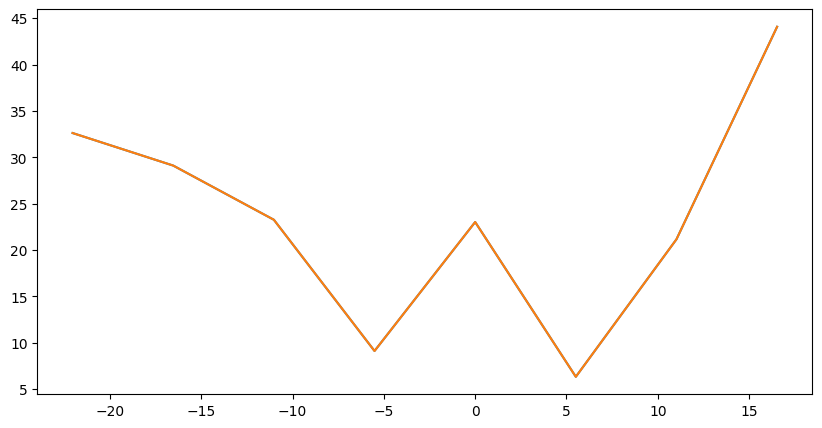

In [4]:
plt.figure(figsize=(10,5))
plt.plot(freqs / 1e3, 20*np.log(spectrum), label="Scipy")
plt.plot(freqs / 1e3, 20*np.log(spectrum_btf), label="Btf")

In [5]:
def vector2file_cfloat(data: np.array, file: str, plio = 128, bits = 16, scale: bool=True):
    """
    data: samples
    file: output filename
    plio: bit width of the PLIO port
    bits: bit precision per sample
    """
    """Scale signal to use full precision"""
    maxr = np.max(np.abs(data.real))
    maxi = np.max(np.abs(data.imag))
    maxv = maxr if maxr > maxi else maxi
    if scale:
        vscale = 2**int(np.floor(np.log2((1 << (bits-1)) / maxv)))
    else:
        vscale = 1
    data = data * (vscale if scale else 1)
    """Write value to file"""
    with open(file, 'w', newline='') as f:
        for i, v in enumerate(data):
            r = np.float32(v.real)
            c = np.float32(v.imag)
            f.write("{} {} ".format(r, c))
            if (((i+1) % 2) == 0 and plio == 128) or (((i+1) % 2) == 1 and plio == 64):
                f.write('\n')
    
    return vscale

In [6]:
vscale=vector2file_cfloat(signal, 'DataInFFT0.txt', scale=False)
# print(vscale)
# vector2file_cfloat(signal, 'DataInFIR0.txt', scale=True)
# vector2file_cfloat(spectrum, 'DataOutFFT0.txt', scale=True)

#### WAIT! ! ! AIE! ! !

In [7]:
import csv
def read_file(file: str, samples: int):
    value = np.zeros(samples, dtype=np.complex128)
    count = 0
    with open(file,'r') as f:
        reader = csv.reader(f, delimiter=" ")
        for line in reader:
            if 'T' in line[0]:
                continue
            for i in range(0, len(line), 2):
                if line[i] != '':
                    value[count] = float(line[i]) + 1j* float(line[i+1])
                    count = count + 1
    return value

In [8]:
# Use the output file from the AIE, now using SciPy file for simplicity
signal_read = read_file('DataOutFFT0.txt', nsamples)

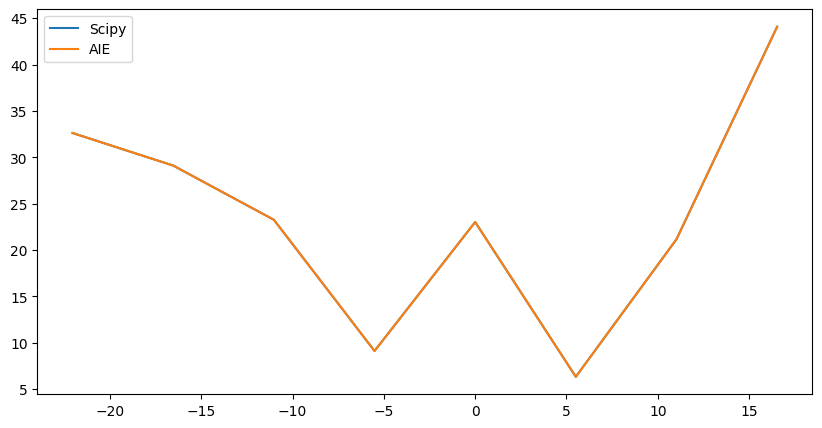

In [9]:
# scaled_in = read_file('DataInFFT0.txt', nsamples)
# spectrum, _ = compute_fft(scaled_in,fs)

plt.figure(figsize=(10,5))
plt.plot(freqs / 1e3, 20*np.log(spectrum), label="Scipy")
plt.plot(freqs / 1e3, 20*np.log(signal_read/vscale), label="AIE")
#plt.plot(freqs / 1e3, 20*np.log(signal_read), label="AIE")
plt.legend()

In [10]:
np.array_equal(spectrum, signal_read)

False

In [11]:
np.isclose(spectrum, signal_read, 2, 2)

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [12]:
error = spectrum - signal_read

In [13]:
np.max(np.abs(error.real))

4.053450393115554e-07

In [14]:
np.max(np.abs(error.imag))

4.3760837264983365e-07

In [15]:
def findmax(fftnp, fftaie):
    print(f'Numpy: Max Real {np.max(np.abs(fftnp.real))}, Max Imag {np.max(np.abs(fftnp.imag))}')
    print(f'Numpy: Max Real {np.max(np.abs(fftaie.real))}, Max Imag {np.max(np.abs(fftaie.imag))}')

findmax(spectrum, signal_read)

Numpy: Max Real 6.463568281654961, Max Imag 6.349540360367917
Numpy: Max Real 6.463568687, Max Imag 6.34954071
